# Methods for Global Interpretations

Global interpretations of a machine learning aims to provide an overall assessment of the relative importance of different features in predicting the outcome / target. In this chapter, we will look at several common global interpretation methods, including both model-specific methods (e.g., feature importance for ensemble techniques) and model-agnostic methods (such as PDP and ALE plots).

## Model-Specific Method: Feature Importance

Many tree-based ensemble learning techniques, such as random forest and gradient boosting (XGBoost and LightGBM) naturally offer a global interpretation mechanism, via **feature importance**. Using the [Bank Marketing dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing), we will demonstrate how to obtain and visualize feature importance, and more crucially, try to understand what it actually means.

```{admonition} Data: Bank Marketing
:class: note
- Location: "data/bank-full.csv"
- Shape: (45211, 17)
- Note: this is a commonly used dataset for benchmarking ML algorithms. The goal is typically to predict ```y``` (whether a customer subscribed to a term deposit) based on other features.
```

In [76]:
# import data
import pandas as pd
bank = pd.read_csv('../data/bank-full.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [77]:
X = bank.drop('y', axis = 1)
Y = bank['y']
# converting categorical variables to dummies
X = pd.get_dummies(X, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], dtype=int)
# converting yes / no in outcome variable to 1 / 0
Y = Y.map(dict(yes = 1, no = 0))

In [78]:
# for illustration, let's build a random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# we will use 70% of the data for training and 30% for testing
# setting random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

# train the random forest classifier
# this dataset is quite imbalanced, so we will set class_weight to balanced
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
rf_clf.fit(X_train, y_train)

# to get feature importances
importances = rf_clf.feature_importances_
# put importance scores in a DataFrame for easy inspection
importances_df = pd.Series(importances, index = X.columns)

Text(0.5, 1.0, 'Feature importances')

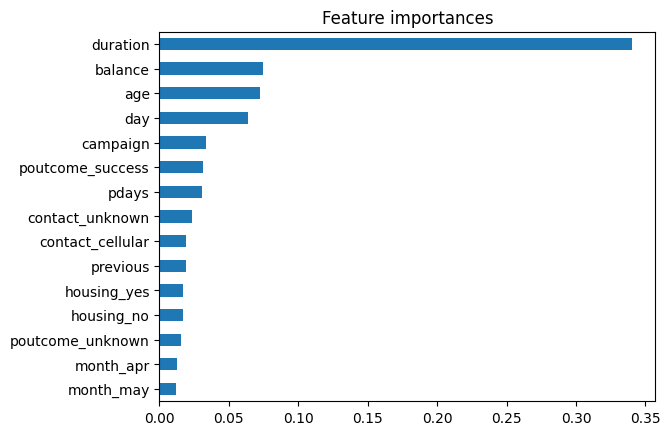

In [29]:
# visually, we can try to plot a bar chart of top-15 most important features, in descending order
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
importances_df.sort_values(ascending = False, inplace = True)
importances_df = importances_df[:15]
importances_df.plot.barh(ax = ax)
ax.invert_yaxis()
ax.set_title("Feature importances")

From the plot, it seems that ```duration``` (duration since last telemarketing contact) is the most predictive feature, and ```balance``` (yearly account balance), ```age``` (age of client), ```day``` (day of the month of last contact) are all somewhat important. While this plot is very often presented as a form of "interpretation" of ensemble models, what exactly does each feature importance value mean? Take ```duration``` as an example, its importance is 0.340, what does this number mean?

In fact, the feature importance value measures the **reduction of impurity brought by a given feature**, averaged overall all trees in the ensemble. In a decision tree, each split is determined by identifying a feature (and an associated value of that feature) that produces largest impurity reduction (where impurity may be measured by entropy or Gini). Impurity reduction of a given feature therefore reflects its "usefulness" in the decisiont tree. Averaging impurity reduction over all trees, we get an overall, ensemble-level feature importance measure.

Because the feature importance values are averaged over all trees, we can also quantify their variances, as a signal of the variability of feature importance among constituent models within the ensemble. The following code visualizes that.

Text(0.5, 1.0, 'Feature importances')

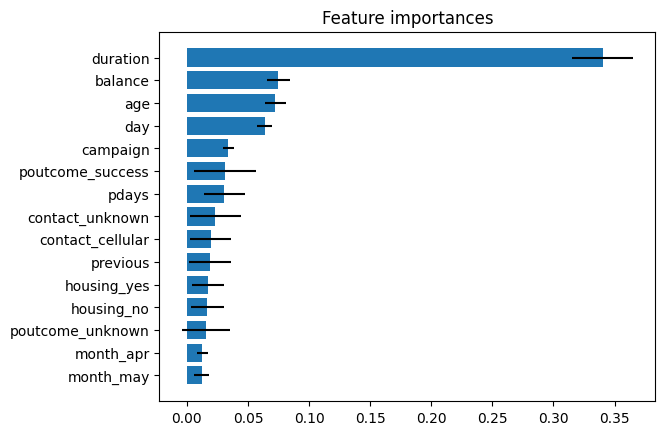

In [32]:
import numpy as np
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
importances_df2 = pd.DataFrame({'score': importances, 'score_std': std}, index = X.columns)
fig, ax = plt.subplots()
importances_df2.sort_values(by=['score'], ascending = False, inplace = True)
importances_df2 = importances_df2[:15]
ax.barh(y = importances_df2.index, width = importances_df2['score'], xerr = importances_df2['score_std'])
ax.invert_yaxis()
ax.set_title("Feature importances")

## Model-Agnostic Methods

While the above feature importance plot is a useful interpretation method for tree-based ensemble techniques, it is not easily generalizable to other ML techniques. Now, we turn our attention to a few global interpretation methods that are model-agnostic, i.e., they can be used as a "wrapper" on top of arbitrary models.

### Partial Dependency Plot (PDP)

PDP {cite:p}`hastie2009elements` is a straightforward (yet somewhat naïve) approach to quantify the effect of a feature on ML predictions. Specifically, for a given "focal" feature, it simply computes the average prediction when the focal feature takes a particular value, averaging over all possible values of other features in order to "marginalize" their effects on the predictions. What you get is an "isolated" measure of the effect of the focal feature on predictions. Then, plotting that effect measure across different values the focal feature can take, you get a plot illustrating the dependency of predictions on the focal feature. 

```{admonition} Maths behind PDP (optional, toggle to show)
:class: dropdown
For simplicity, suppose two features, $X_1$ and $X_2$, are used to build a ML model. Given a specific pair of feature values $(x_1, x_2)$, denote the prediction generated by the ML model as $f(x_1,x_2)$. Further denote $p_1(.)$ and $p_2()$ as the probability density function of feature $X_1$ and $X_2$, and $p_{2\|1}(.)$ as the conditional density of feature $X_2$ on feature $X_1$.

Under PDP, for a given feature value $x_1$, it simply computes the *average prediction* when $X_1 = x_1$, and the "average" is taken over all possible values of $X_2$, in order to "marginalize" the effect of the second feature on predictions. More precisely, PDP computes:

$$
f_{1,PDP}(x_1) = \mathbb{E}(f(x_1, X_2)) = \int p_2(x_2) f(x_1, x_2) dx_2
$$
then plots $f_{1,PDP}(x_1)$ against $x_1$ for different values of $x_1$.

```

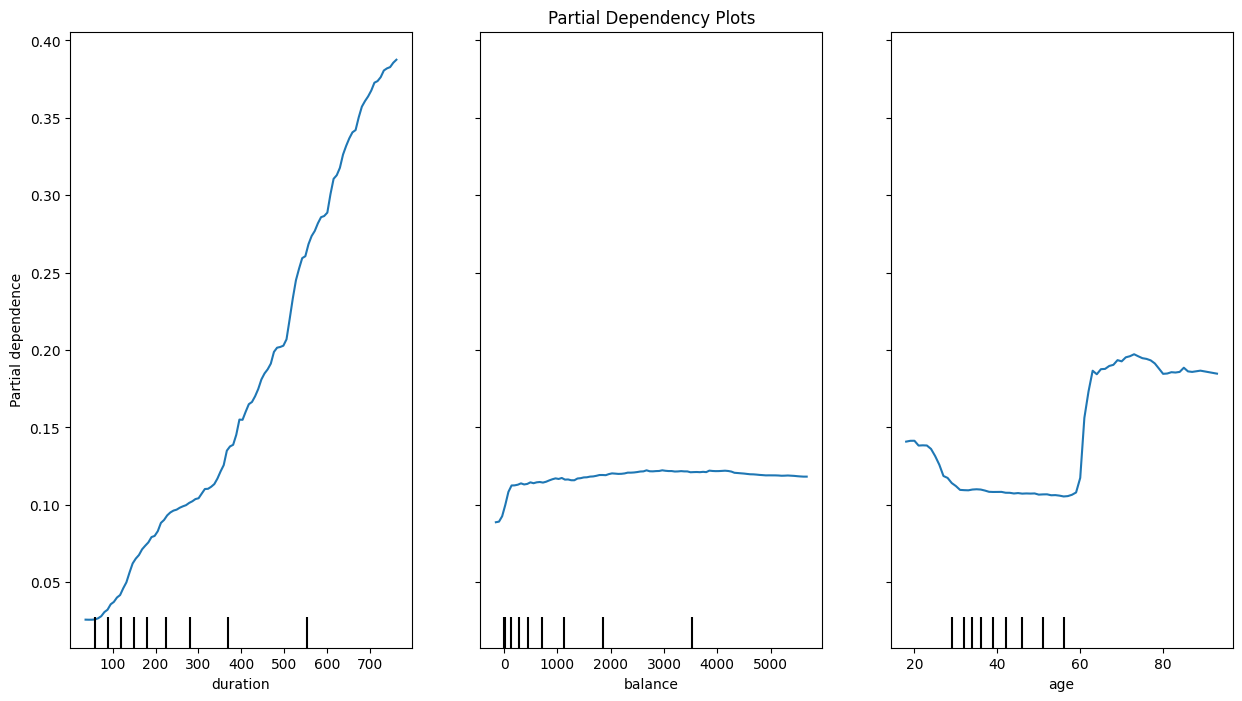

In [44]:
from sklearn.inspection import PartialDependenceDisplay
# let's get PDP of the above random forest classifier for feature "duration", "balance", and "age"
# "estimator" takes the random forest classifier
# "X" takes a set of data (with all features) over which to compute the partial dependency values
# "features" takes the indices of the features for which we want to compute the partial dependency values
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Partial Dependency Plots")
PartialDependenceDisplay.from_estimator(estimator = rf_clf, 
                                        X = X_test, 
                                        features = ["duration", "balance", "age"],
                                        ax = ax)

We can see that the effect of ```duration``` on probability of subscribing to the term deposit is largely linear - higher the duration, greater the probability of subscription. As for ```balance```, we see a positive effect for lower balance, but after certain point, it does not seem to matter. Finally, we see a non-linear relationship between ```age``` and probability of subscription. As the client's age increases, there is an initial decrease in subscription probability to a steady level, followed by a sharp increase in subscription probability beyond 60 years old or so.

Despite its intuitive nature, PDP makes an important, and often unrealistic assumption that features are independent of each other (this allows straightforward marginalization of other features for a given focal feature). When this assumption fails, which it usually does, PDP can be somewhat misleading. The next method is a candidate for addressing this limitation.

### Accumulated Local Effects (ALE) Plot

Accumulated local effects (ALE) is a method to quantify the effect of a focal feature while not having to assume its independence from other features. It computes the "marginal effect" of the focal feature on predictions, then accumulates such marginal effects (over a range of values that the focal feature can take) in order to obtain an overall effect measure. The math behind ALE is somewhat complicated - feel free to toggle the following block for more details, but it's also ok to skip.

```{admonition} Maths behind ALE (optional, toggle to show)
:class: dropdown
Under the same setting as PDP, ALE computes:

$$
f_{1,ALE}(x_1) = \int_{\min(X1)}^{x_1} \mathbb{E}(f^1 (X_1, X_2)|X_1 = z_1) dz_1 = \int_{\min(X1)}^{x_1} \int p_{2|1}(x_2|z_1) f^1(z_1, x_2) dx_2 dz_1
$$

where $f^1(z_1, x_2)$ is the partial derivative of prediction w.r.t. the first feature, i.e., $f^1(z_1, x_2)=\frac{\partial f(z_1,x_2)}{\partial z_1}$, which measures the "marginal effect" of $X_1$ on the predictions in the neighborhood of $X_1 = z_1$. Then, such marginal effects are accumulated from the minimum value that $X_1$ takes, up to the focal value $x_1$. Finally, $f_{1,ALE}(x_1)$ is plotted against $x_1$ for different values of $x_1$ to get the ALE plot.

The partial derivative, $f^1(z_1, x_2)$, is the key of ALE. For a clearer illustration, imagine a simplified case where $f(x_1,x_2) := \beta_1 x_1 + \beta_2 x_2$, then we have $f^1 (z_1, x_2) = \beta_1$, and consequently, 
\begin{align*}
f_{1,ALE}(x_1) & = \int_{\min(X1)}^{x_1} \int p_{2|1}(x_2|z_1) \beta_1 dx_2 dz_1 \\
& = \int_{\min(X1)}^{x_1} \beta_1 \int p_{2|1}(x_2|z_1) dx_2 dz_1 \\ 
& = \int_{\min(X1)}^{x_1} \beta_1 dz_1 \\
& = \beta_1 x_1 - \beta_1 \min(X_1) = \beta_1 x_1 - constant
\end{align*}
This explains why $f_{1,ALE}(x_1)$ correctly recovers the pure effect of $X_1$, without being confounded by $X_2$.
```

Next, let's try to make an ALE plot using the ```alibi``` package.

array([[<Axes: xlabel='duration', ylabel='ALE'>,
        <Axes: xlabel='balance', ylabel='ALE'>,
        <Axes: xlabel='age', ylabel='ALE'>]], dtype=object)

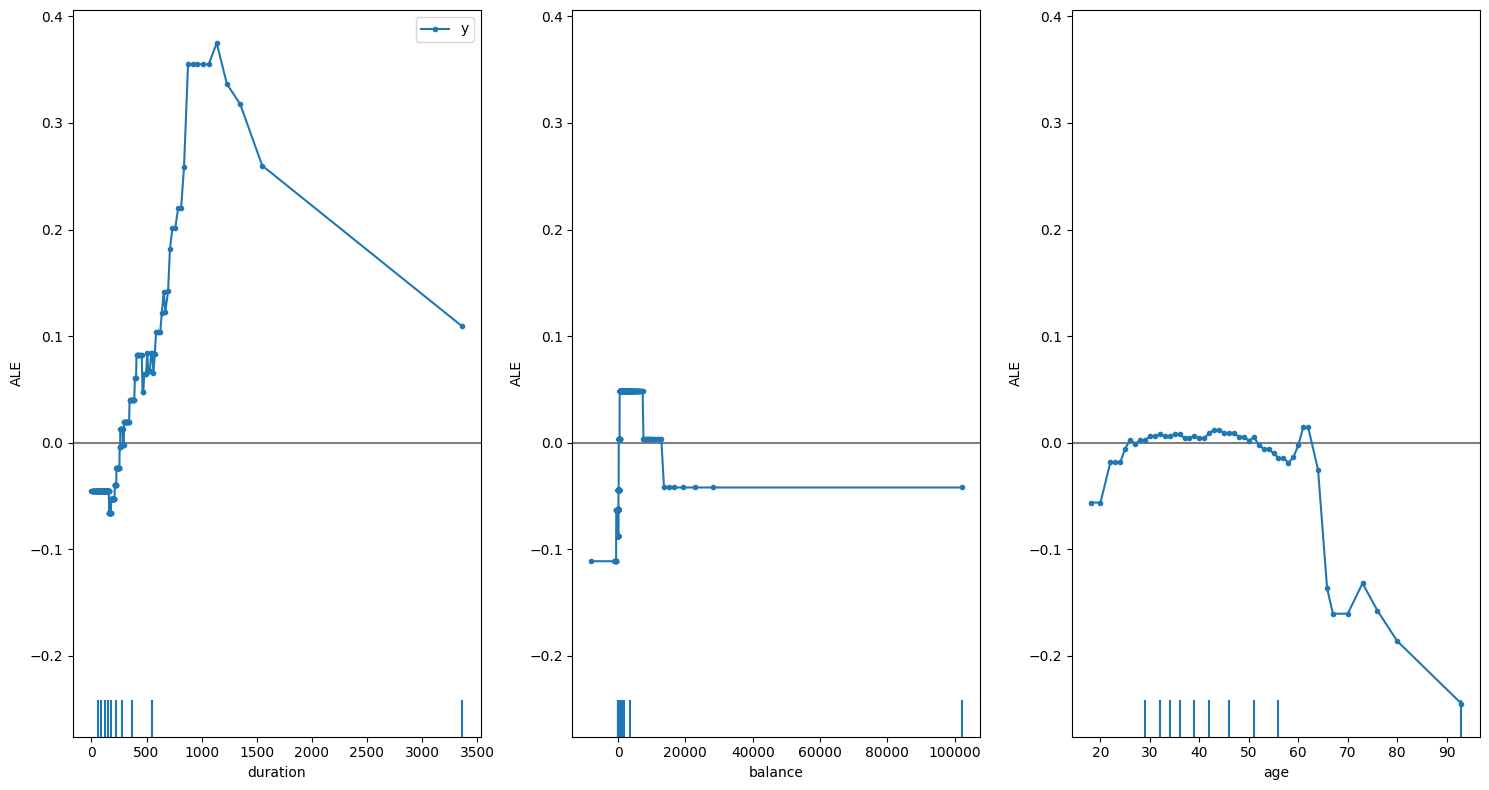

In [85]:
from alibi.explainers import ALE, plot_ale
# this implementation requires numpy arrays rather than pandas DataFrame as inputs
# re-training the same random forest model with numpy arrays
x_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
rf_clf_np = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
rf_clf_np.fit(x_train_np, y_train_np)

# inputs to ALE include the predict function of the model as well as  feature / target names (for plotting)
ale_explainer = ALE(rf_clf_np.predict, feature_names = X.columns, target_names = ['y'])
# also, features to explain need to be specified by indices
ale_exp = ale_explainer.explain(X_test_np, features = [3, 1, 0])
plot_ale(ale_exp, n_cols = 3, fig_kw = {'figwidth': 15, 'figheight': 8})

We get quite different interpretations from those under PDP. Most notably,, relationship between ```age``` and subscription probability is not the same. For clients older than 60, ALE shows that the effect of age on subscription probability becomes negative and decreasing.